The goal of this project was to extract questions users posted on Stack Overflow's parent website, Stack Exchange and use machine learning to predict whether a posted user question would be flagged or not. This was part of a 4 week data science series organized by the Portland Data Science Meetup group in which data science enthusiasts got together and worked on this project. We exchanged ideas and each person was responsible for writing up their results. This is my report

My team members were: Sicelo, Ryan, Sagi, Megan, Shalika, Ravi, Anand, and Jagadesh

In [10]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [26]:
df = pd.read_csv('C:/Users/sicel/Desktop/Portland Data Science/DataScience/14000flaggedunflagged.csv')
df.head()

,body,flag_id
0,<p>I want to read JT 3D file in c++. I am able...,1
1,<p>I had to solve a Capacitated Orienteering P...,1
2,<p>The SSLServerSocket below blocks in in.read...,1
3,<p>Graph seems to be returning invalid retry-a...,1
4,"<p>componentDidMount(){\n fetch('<a href=""h...",1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
body       13996 non-null object
flag_id    14000 non-null int64
dtypes: int64(1), object(1)
memory usage: 218.8+ KB


In [14]:
df.shape

(14000, 2)

In [15]:
# 1 is flagged and 0 is not flagged
df['flag_id'].value_counts()

1    7000
0    7000
Name: flag_id, dtype: int64

In [16]:
# Print out missing rows
null_data = df[df.isnull().any(axis=1)]
null_data.head(10)

,body,flag_id
8645,NaN,0
8751,NaN,0
10628,NaN,0
11647,NaN,0


# DATA CLEANING

In [17]:
from bs4 import BeautifulSoup

In [27]:
# Awesome, I was able to use BeautifulSoup to extract text between html tags
df['body_clean'] = df.body.apply(lambda x: BeautifulSoup(str(x), "lxml").get_text())
df.head()

,body,flag_id,body_clean
0,<p>I want to read JT 3D file in c++. I am able...,1,I want to read JT 3D file in c++. I am able to...
1,<p>I had to solve a Capacitated Orienteering P...,1,I had to solve a Capacitated Orienteering Prob...
2,<p>The SSLServerSocket below blocks in in.read...,1,The SSLServerSocket below blocks in in.read() ...
3,<p>Graph seems to be returning invalid retry-a...,1,Graph seems to be returning invalid retry-afte...
4,"<p>componentDidMount(){\n fetch('<a href=""h...",1,componentDidMount(){\n fetch('https://bobob...


In [28]:
# Print a few rows to see how clean the text looks. A few rows shows a lot of these expressions, \n
df.loc[10,'body_clean']

'I am new to Purescript so I don\'t know how to show multiple SVGs in one div.\nI researched some code examples and implemented this codebase but it has issues.\nWhat is wrong with this code?\nrenderView :: State -> H.ComponentHTML Query\nrenderView state = let\n    {vertices, edges} = state.shape\n    {currentId, shapes} = state.shapeCnt\n    vert2Ds = map project vertices\n  in\n    HH.div_\n      [\n        HH.div [] $\n          [ renderButton "rotX++" (IncAngVelocity X)\n          , renderButton "rotY++" (IncAngVelocity Y)\n          , renderButton "rotZ++" (IncAngVelocity Z)\n          , renderButton "Add Cube" (AddCube)\n          , renderButton "Remove Cube" (RemoveCube)\n          ],\n\n        HH.div_ $ flip map shapes \\sid ->\n          Tuple (show sid) $\n            [ SE.svg\n              [ SA.viewBox 0.0 0.0 viewBoxSize viewBoxSize ]\n              [ SE.g []\n                (drawCube edges vert2Ds)\n              ]\n            ]\n      ]\n\n'

In [29]:
# Also convert to lowercase
df['body_clean'] = df['body_clean'].str.replace('\n', ' ')
df['body_clean'] = df['body_clean'].str.lower()
df.loc[10, 'body_clean']

'i am new to purescript so i don\'t know how to show multiple svgs in one div. i researched some code examples and implemented this codebase but it has issues. what is wrong with this code? renderview :: state -> h.componenthtml query renderview state = let     {vertices, edges} = state.shape     {currentid, shapes} = state.shapecnt     vert2ds = map project vertices   in     hh.div_       [         hh.div [] $           [ renderbutton "rotx++" (incangvelocity x)           , renderbutton "roty++" (incangvelocity y)           , renderbutton "rotz++" (incangvelocity z)           , renderbutton "add cube" (addcube)           , renderbutton "remove cube" (removecube)           ],          hh.div_ $ flip map shapes \\sid ->           tuple (show sid) $             [ se.svg               [ sa.viewbox 0.0 0.0 viewboxsize viewboxsize ]               [ se.g []                 (drawcube edges vert2ds)               ]             ]       ]  '

In [30]:
# Remove whitespaces.
df['body_clean'] = df['body_clean'].str.replace("  "," ")
df.loc[10, 'body_clean']

'i am new to purescript so i don\'t know how to show multiple svgs in one div. i researched some code examples and implemented this codebase but it has issues. what is wrong with this code? renderview :: state -> h.componenthtml query renderview state = let   {vertices, edges} = state.shape   {currentid, shapes} = state.shapecnt   vert2ds = map project vertices  in   hh.div_    [     hh.div [] $      [ renderbutton "rotx++" (incangvelocity x)      , renderbutton "roty++" (incangvelocity y)      , renderbutton "rotz++" (incangvelocity z)      , renderbutton "add cube" (addcube)      , renderbutton "remove cube" (removecube)      ],     hh.div_ $ flip map shapes \\sid ->      tuple (show sid) $       [ se.svg        [ sa.viewbox 0.0 0.0 viewboxsize viewboxsize ]        [ se.g []         (drawcube edges vert2ds)        ]       ]    ] '

In [31]:
# Include only alpha characters. Everything except a-zA-Z gets replaced with empty string

import re

df.body_clean = df.body_clean.apply(lambda x: re.sub('[^a-zA-Z\s]', '', x))
df.head()

,body,flag_id,body_clean
0,<p>I want to read JT 3D file in c++. I am able...,1,i want to read jt d file in c i am able to acc...
1,<p>I had to solve a Capacitated Orienteering P...,1,i had to solve a capacitated orienteering prob...
2,<p>The SSLServerSocket below blocks in in.read...,1,the sslserversocket below blocks in inread in ...
3,<p>Graph seems to be returning invalid retry-a...,1,graph seems to be returning invalid retryafter...
4,"<p>componentDidMount(){\n fetch('<a href=""h...",1,componentdidmount fetchhttpsboboboionlinecap...


In [32]:
# Looks better after cleaning
df.loc[10, 'body_clean']

'i am new to purescript so i dont know how to show multiple svgs in one div i researched some code examples and implemented this codebase but it has issues what is wrong with this code renderview  state  hcomponenthtml query renderview state  let   vertices edges  stateshape   currentid shapes  stateshapecnt   vertds  map project vertices  in   hhdiv         hhdiv         renderbutton rotx incangvelocity x       renderbutton roty incangvelocity y       renderbutton rotz incangvelocity z       renderbutton add cube addcube       renderbutton remove cube removecube           hhdiv  flip map shapes sid       tuple show sid         sesvg         saviewbox   viewboxsize viewboxsize          seg          drawcube edges vertds                    '

In [35]:
# Create a body length column
df['length'] = df.body_clean.apply(lambda x: len(x))
df.head()

,body,flag_id,body_clean,length
0,<p>I want to read JT 3D file in c++. I am able...,1,i want to read jt d file in c i am able to acc...,207
1,<p>I had to solve a Capacitated Orienteering P...,1,i had to solve a capacitated orienteering prob...,1297
2,<p>The SSLServerSocket below blocks in in.read...,1,the sslserversocket below blocks in inread in ...,1078
3,<p>Graph seems to be returning invalid retry-a...,1,graph seems to be returning invalid retryafter...,542
4,"<p>componentDidMount(){\n fetch('<a href=""h...",1,componentdidmount fetchhttpsboboboionlinecap...,689


In [39]:
# Do flagged questions tend to be longer than unflagged questions? Looks like
df2 = df.groupby('flag_id')
df2.head()
df2.describe()

length                                                               
          count        mean          std   min    25%    50%      75%      max
flag_id                                                                       
0        7000.0  916.273429  1281.768673   3.0  305.0  569.0  1043.25  20364.0
1        7000.0  826.264714  1361.752153  31.0  245.0  450.0   881.25  23327.0

Text(0, 0.5, 'Count')

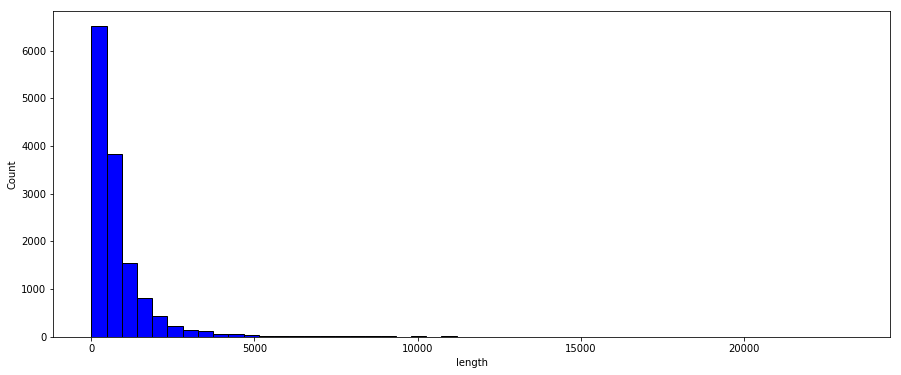

In [40]:
# Plot a histogram of column length
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.hist(df['length'], color = 'blue', edgecolor = 'black', bins = 50)
plt.xlabel('length')
plt.ylabel('Count')

In [41]:
# Use NLTK to extract individual words from body

import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sicel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
# Visualize most common words in the 2 categories
# Select only flagged category first

flagged = df[df.flag_id==1]
flagged.head()

,body,flag_id,body_clean,length
0,<p>I want to read JT 3D file in c++. I am able...,1,i want to read jt d file in c i am able to acc...,207
1,<p>I had to solve a Capacitated Orienteering P...,1,i had to solve a capacitated orienteering prob...,1297
2,<p>The SSLServerSocket below blocks in in.read...,1,the sslserversocket below blocks in inread in ...,1078
3,<p>Graph seems to be returning invalid retry-a...,1,graph seems to be returning invalid retryafter...,542
4,"<p>componentDidMount(){\n fetch('<a href=""h...",1,componentdidmount fetchhttpsboboboionlinecap...,689


In [45]:
tokenizer = RegexpTokenizer('\w+')

flag_words = []
for word in flagged['body_clean']:
  flag_words.append(word)
print(flag_words[:2])

['i want to read jt d file in c i am able to access vertices and normal but i am struggling to access indexed triangles without indexed triangle three js not able to render d model properly please help me out ', 'i had to solve a capacitated orienteering problem with time windows and i should implement it in cplex but the constrait of the time windows does not work could anyone solve this problem i assume that the problem has something to do with the time windows but i am not sure                                                  input data defined externally  number of control points int n    set of control point indices int n    score at each control point int pn    distance matrix travel time int tnn    maximum distance int tmax   time xindow int on   int cn  demand int demandn   service time int servicetimen  capacity int cap  m variable int m  decision variable dvar boolean xnn  dvar float bn objective function dexpr float profit  sumi in n j in n             pixij maximize profit 

In [47]:
# Print out first 10 words
flagtokens = tokenizer.tokenize(str(flag_words))
flagtokens[:10]

['i', 'want', 'to', 'read', 'jt', 'd', 'file', 'in', 'c', 'i']

In [48]:
# Remove stopwords
sw = nltk.corpus.stopwords.words('english')
words_flag = []
for word in flagtokens:
    if word not in sw:
        words_flag.append(word)
words_flag[:10]

['want',
 'read',
 'jt',
 'file',
 'c',
 'able',
 'access',
 'vertices',
 'normal',
 'struggling']

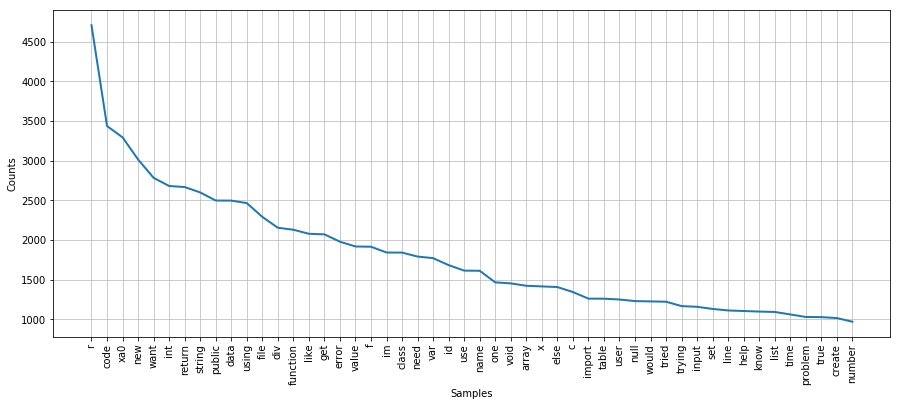

In [49]:
# Create frequency distribution and plot

flagged_common = nltk.FreqDist(words_flag)
flagged_common.plot(50)

# MACHINE LEARNING: MODEL TRAINING, TESTING AND EVALUATION

In [67]:
# Import Sklearn Modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix

In [68]:
# Split the data into 80% training  and 20% test data
X = df['body_clean'] # Features
y = df['flag_id']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

Use TF-IDF statistic (term frequency-inverse document frequency) to turn comment text into numerical data. TF determines the frequency of a word and IDF decreases the weight for commonly used words and increases the weight of less commonly used words. I also found that removing stop words does not change accuracy score that much

1. RANDOM FOREST

In [54]:
tf_vect = TfidfVectorizer(lowercase=True, use_idf=True, smooth_idf=True, sublinear_tf=False)

X_train = tf_vect.fit_transform(X_train)
X_test = tf_vect.transform(X_test)

# Train the model on a training set. n_estimators is the number of decision trees in the forest

clf = RandomForestClassifier(n_estimators = 50, random_state = 5)
clf.fit(X_train, y_train)

# Predict on a training dataset

y_pred = clf.predict(X_test)

# Print the model accuracy score and RMSE

print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Random Forest RMSE:", mean_squared_error(y_test, y_pred))

Random Forest Accuracy: 0.7696428571428572
Random Forest RMSE: 0.23035714285714284


In [57]:
# Print out F1-score which is the harmonic mean between precision and recall. Accuracy score alone can be misleading
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1412
           1       0.77      0.76      0.77      1388

   micro avg       0.77      0.77      0.77      2800
   macro avg       0.77      0.77      0.77      2800
weighted avg       0.77      0.77      0.77      2800



In [58]:
print(confusion_matrix(y_test, y_pred))

[[1094  318]
 [ 327 1061]]


In [59]:
# Below I print out the number of unique elements of an array that the model can predict by the following:

print(np.unique(y_pred))

[0 1]


2. NAIVE BAYES

In [61]:
tf_vect = TfidfVectorizer(lowercase=True, use_idf=True, smooth_idf=True, sublinear_tf=False)

X_train = tf_vect.fit_transform(X_train)
X_test = tf_vect.transform(X_test)

# Train the model on a training set.

clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict on a training dataset

y_pred = clf.predict(X_test)

# Print the model accuracy score and RMSE

print("Naive Bayes Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Naive Bayes RMSE:", mean_squared_error(y_test, y_pred))

Naive Bayes Accuracy: 0.7625
Naive Bayes RMSE: 0.2375


3. LOGISTIC REGRESSION

In [66]:
tf_vect = TfidfVectorizer(lowercase=True, use_idf=True, smooth_idf=True, sublinear_tf=False)

X_train = tf_vect.fit_transform(X_train)
X_test = tf_vect.transform(X_test)

# Train the model on a training set.

clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict on a training dataset

y_pred = clf.predict(X_test)

# Print the model accuracy score and RMSE

print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Logistic Regression RMSE:", mean_squared_error(y_test, y_pred))

C:\Users\sicel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy: 0.7678571428571429
Logistic Regression RMSE: 0.23214285714285715


4. SUPPORT VECTOR MACHINE

In [70]:
# In support vector classification, C is the penalty paramter of the error term. Default = 1

# So far SVM gives the highest score

tf_vect = TfidfVectorizer(lowercase=True, use_idf=True, smooth_idf=True, sublinear_tf=False)
X_train = tf_vect.fit_transform(X_train)
X_test = tf_vect.transform(X_test)

C = 1.0
svc = svm.SVC(kernel='linear', C=C).fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc.score(X_test, y_test)

0.7760714285714285

In [71]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.80      0.73      0.77      1412
           1       0.75      0.82      0.78      1388

   micro avg       0.78      0.78      0.78      2800
   macro avg       0.78      0.78      0.78      2800
weighted avg       0.78      0.78      0.78      2800



In [72]:
print(confusion_matrix(y_test, svc_pred))

[[1036  376]
 [ 251 1137]]


5. ARTIFICIAL NEURAL NETWORKS

 I found this great tutorial online to help guide me: https://realpython.com/python-keras-text-classification/

In [73]:
# Import relevant libraries
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import cross_val_score
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [74]:
text = df['body_clean'].values # Features
y = df['flag_id'].values  # Labels
text_train, text_test, y_train, y_test = train_test_split(text, y, test_size = 0.2, random_state = 100)

In [75]:
tf_vect = TfidfVectorizer(lowercase=True, use_idf=True, smooth_idf=True, sublinear_tf=False)

X_train = tf_vect.fit_transform(text_train)
X_test = tf_vect.transform(text_test)
X_train

<11200x107966 sparse matrix of type '<class 'numpy.float64'>'
	with 693549 stored elements in Compressed Sparse Row format>

We have 11200 samples after train/test split. Each sample has 107966 dimensions, which is the size of the vocabulary. A sparse matrix is optimized for a matrix with non-zero elements

In [76]:
# For neural networks, need to know the input dimension of feature vectors
input_dim = X_train.shape[1]
input_dim

107966

In [77]:
model = Sequential()
model.add(Dense(32, input_dim = input_dim, activation = 'relu'))

# Use a sigmoid function for the output layer in a binary classification problem or a softmax function for multi-class classification problems
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

# Before training the model, need to configure the learning process using .compile() method. This model specifies the optimizer and loss function
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print out model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                3454944   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,454,977
Trainable params: 3,454,977
Non-trainable params: 0
_________________________________________________________________


In [78]:
# I started with 8 epochs and changed it to 4 since it takes a long time to run 8 epochs
# Setting verbose to 1 prints out a line which shows progress of the model as it trains
# Validation data: the model will not be trained on this data
#Batch size: If unspecified default is 32. The number of samples used in one iteration or epoch

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs=4, 
                    verbose=1, 
                    validation_data=(X_test, y_test))

Train on 11200 samples, validate on 2800 samples
Epoch 1/4
11200/11200 [==============================] - 51s 5ms/step - loss: 0.6166 - acc: 0.7251 - val_loss: 0.5079 - val_acc: 0.7743
Epoch 2/4
11200/11200 [==============================] - 50s 4ms/step - loss: 0.3353 - acc: 0.8921 - val_loss: 0.4509 - val_acc: 0.7779
Epoch 3/4
11200/11200 [==============================] - 50s 4ms/step - loss: 0.1613 - acc: 0.9590 - val_loss: 0.4551 - val_acc: 0.7818
Epoch 4/4
11200/11200 [==============================] - 50s 4ms/step - loss: 0.0832 - acc: 0.9846 - val_loss: 0.4776 - val_acc: 0.7829


In [79]:
# Evaluate the accuracy of the model

loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(accuracy)

2800/2800 [==============================] - 6s 2ms/step
0.7828571428571428
